In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#@title Binvox Read Write
#  Copyright (C) 2012 Daniel Maturana
#  This file is part of binvox-rw-py.
#
#  binvox-rw-py is free software: you can redistribute it and/or modify
#  it under the terms of the GNU General Public License as published by
#  the Free Software Foundation, either version 3 of the License, or
#  (at your option) any later version.
#
#  binvox-rw-py is distributed in the hope that it will be useful,
#  but WITHOUT ANY WARRANTY; without even the implied warranty of
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#  GNU General Public License for more details.
#
#  You should have received a copy of the GNU General Public License
#  along with binvox-rw-py. If not, see <http://www.gnu.org/licenses/>.
#

import numpy as np

class Voxels(object):
    """ Holds a binvox model.
    data is either a three-dimensional numpy boolean array (dense representation)
    or a two-dimensional numpy float array (coordinate representation).

    dims, translate and scale are the model metadata.

    dims are the voxel dimensions, e.g. [32, 32, 32] for a 32x32x32 model.

    scale and translate relate the voxels to the original model coordinates.

    To translate voxel coordinates i, j, k to original coordinates x, y, z:

    x_n = (i+.5)/dims[0]
    y_n = (j+.5)/dims[1]
    z_n = (k+.5)/dims[2]
    x = scale*x_n + translate[0]
    y = scale*y_n + translate[1]
    z = scale*z_n + translate[2]

    """

    def __init__(self, data, dims, translate, scale, axis_order):
        self.data = data
        self.dims = dims
        self.translate = translate
        self.scale = scale
        assert (axis_order in ('xzy', 'xyz'))
        self.axis_order = axis_order

    def clone(self):
        data = self.data.copy()
        dims = self.dims[:]
        translate = self.translate[:]
        return Voxels(data, dims, translate, self.scale, self.axis_order)

    def write(self, fp):
        write(self, fp)

def read_header(fp):
    """ Read binvox header. Mostly meant for internal use.
    """
    line = fp.readline().strip()
    if not line.startswith(b'#binvox'):
        raise IOError('Not a binvox file')
    dims = list(map(int, fp.readline().strip().split(b' ')[1:]))
    translate = list(map(float, fp.readline().strip().split(b' ')[1:]))
    scale = list(map(float, fp.readline().strip().split(b' ')[1:]))[0]
    line = fp.readline()
    return dims, translate, scale

def read_as_3d_array(fp, fix_coords=True):
    """ Read binary binvox format as array.

    Returns the model with accompanying metadata.

    Voxels are stored in a three-dimensional numpy array, which is simple and
    direct, but may use a lot of memory for large models. (Storage requirements
    are 8*(d^3) bytes, where d is the dimensions of the binvox model. Numpy
    boolean arrays use a byte per element).

    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)
    # if just using reshape() on the raw data:
    # indexing the array as array[i,j,k], the indices map into the
    # coords as:
    # i -> x
    # j -> z
    # k -> y
    # if fix_coords is true, then data is rearranged so that
    # mapping is
    # i -> x
    # j -> y
    # k -> z
    values, counts = raw_data[::2], raw_data[1::2]
    data = np.repeat(values, counts).astype(bool)
    data = data.reshape(dims)
    if fix_coords:
        # xzy to xyz TODO the right thing
        data = np.transpose(data, (0, 2, 1))
        axis_order = 'xyz'
    else:
        axis_order = 'xzy'
    return Voxels(data, dims, translate, scale, axis_order)

def read_as_coord_array(fp, fix_coords=True):
    """ Read binary binvox format as coordinates.

    Returns binvox model with voxels in a "coordinate" representation, i.e.  an
    3 x N array where N is the number of nonzero voxels. Each column
    corresponds to a nonzero voxel and the 3 rows are the (x, z, y) coordinates
    of the voxel.  (The odd ordering is due to the way binvox format lays out
    data).  Note that coordinates refer to the binvox voxels, without any
    scaling or translation.

    Use this to save memory if your model is very sparse (mostly empty).

    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)

    values, counts = raw_data[::2], raw_data[1::2]

    sz = np.prod(dims)
    index, end_index = 0, 0
    end_indices = np.cumsum(counts)
    indices = np.concatenate(([0], end_indices[:-1])).astype(end_indices.dtype)

    values = values.astype(np.bool)
    indices = indices[values]
    end_indices = end_indices[values]

    nz_voxels = []
    for index, end_index in zip(indices, end_indices):
        nz_voxels.extend(range(index, end_index))
    nz_voxels = np.array(nz_voxels)
    # TODO are these dims correct?
    # according to docs,
    # index = x * wxh + z * width + y; // wxh = width * height = d * d

    x = nz_voxels / (dims[0]*dims[1])
    zwpy = nz_voxels % (dims[0]*dims[1]) # z*w + y
    z = zwpy / dims[0]
    y = zwpy % dims[0]
    if fix_coords:
        data = np.vstack((x, y, z))
        axis_order = 'xyz'
    else:
        data = np.vstack((x, z, y))
        axis_order = 'xzy'

    #return Voxels(data, dims, translate, scale, axis_order)
    return Voxels(np.ascontiguousarray(data), dims, translate, scale, axis_order)

def dense_to_sparse(voxel_data, dtype=int):
    """ From dense representation to sparse (coordinate) representation.
    No coordinate reordering.
    """
    if voxel_data.ndim!=3:
        raise ValueError('voxel_data is wrong shape; should be 3D array.')
    return np.asarray(np.nonzero(voxel_data), dtype)

def sparse_to_dense(voxel_data, dims, dtype=bool):
    if voxel_data.ndim!=2 or voxel_data.shape[0]!=3:
        raise ValueError('voxel_data is wrong shape; should be 3xN array.')
    if np.isscalar(dims):
        dims = [dims]*3
    dims = np.atleast_2d(dims).T
    # truncate to integers
    xyz = voxel_data.astype(np.int)
    # discard voxels that fall outside dims
    valid_ix = ~np.any((xyz < 0) | (xyz >= dims), 0)
    xyz = xyz[:,valid_ix]
    out = np.zeros(dims.flatten(), dtype=dtype)
    out[tuple(xyz)] = True
    return out

#def get_linear_index(x, y, z, dims):
    #""" Assuming xzy order. (y increasing fastest.
    #TODO ensure this is right when dims are not all same
    #"""
    #return x*(dims[1]*dims[2]) + z*dims[1] + y

def write(voxel_model, fp):
    """ Write binary binvox format.

    Note that when saving a model in sparse (coordinate) format, it is first
    converted to dense format.

    Doesn't check if the model is 'sane'.

    """
    if voxel_model.data.ndim==2:
        # TODO avoid conversion to dense
        dense_voxel_data = sparse_to_dense(voxel_model.data, voxel_model.dims)
    else:
        dense_voxel_data = voxel_model.data

    fp.write('#binvox 1\n')
    fp.write('dim '+' '.join(map(str, voxel_model.dims))+'\n')
    fp.write('translate '+' '.join(map(str, voxel_model.translate))+'\n')
    fp.write('scale '+str(voxel_model.scale)+'\n')
    fp.write('data\n')
    if not voxel_model.axis_order in ('xzy', 'xyz'):
        raise ValueError('Unsupported voxel model axis order')

    if voxel_model.axis_order=='xzy':
        voxels_flat = dense_voxel_data.flatten()
    elif voxel_model.axis_order=='xyz':
        voxels_flat = np.transpose(dense_voxel_data, (0, 2, 1)).flatten()

    # keep a sort of state machine for writing run length encoding
    state = voxels_flat[0]
    ctr = 0
    for c in voxels_flat:
        if c==state:
            ctr += 1
            # if ctr hits max, dump
            if ctr==255:
                fp.write(chr(state))
                fp.write(chr(ctr))
                ctr = 0
        else:
            # if switch state, dump
            fp.write(chr(state))
            fp.write(chr(ctr))
            state = c
            ctr = 1
    # flush out remainders
    if ctr > 0:
        fp.write(chr(state))
        fp.write(chr(ctr))

if __name__ == '__main__':
    import doctest
    doctest.testmod()



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/doctest.py", line 1501, in run
    sys.settrace(save_trace)



In [3]:
#@title Wandb Install

!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title Wandb Imports

import wandb
#wandb.login(key="d57a272a54db383f4776fb3f28f72e9b76a1dc79")
wandb.login()

from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb: Currently logged in as: sara_shonkwiler (additive-parts). Use `wandb login --relogin` to force relogin


In [5]:
#@title Imports
from matplotlib import pyplot as plt
import random
import numpy as np
import tensorflow as tf
import os
import numpy as np
import json
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D, concatenate, MaxPool3D, Dense, Activation, MaxPooling3D, Dropout, Flatten, Reshape, BatchNormalization, AveragePooling3D, Input

In [6]:
#@title Load numpy array

loaded = np.load('/content/gdrive/MyDrive/Research/voxelized_64_parts_0.npz')
models = loaded['a']
scale = loaded['b']
y_labels = loaded['c']

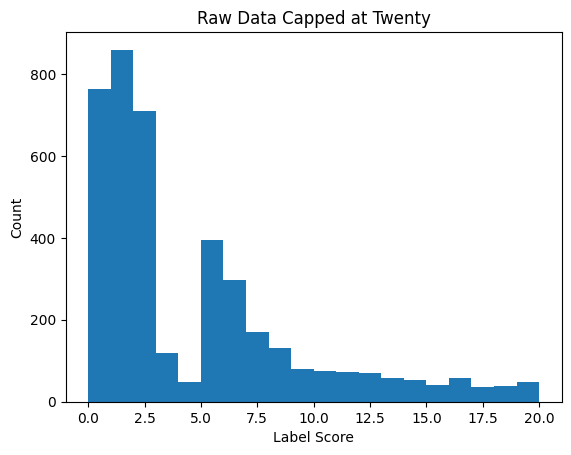

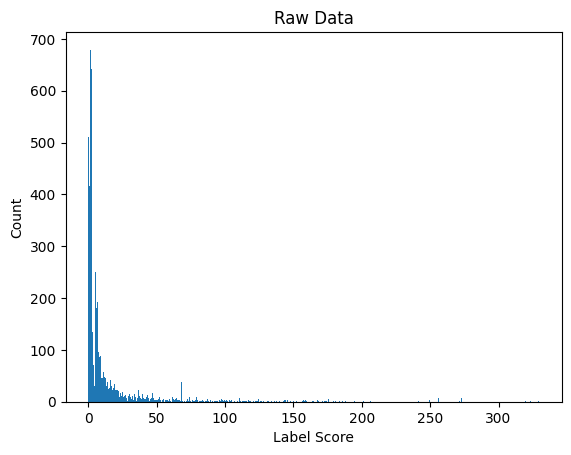

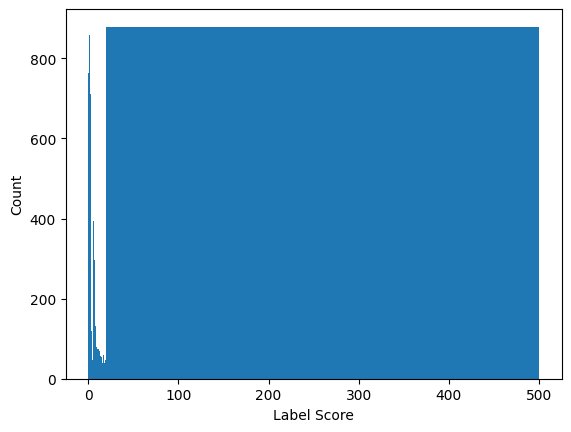

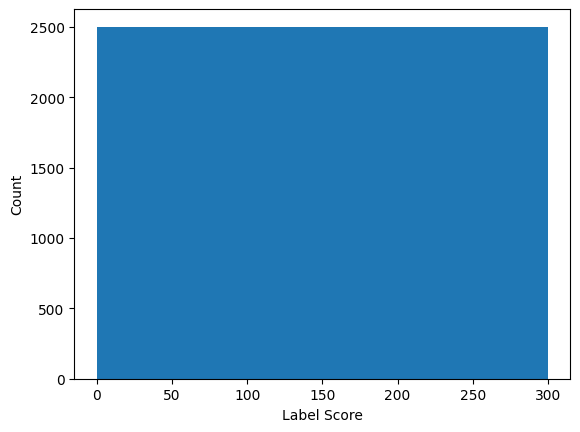

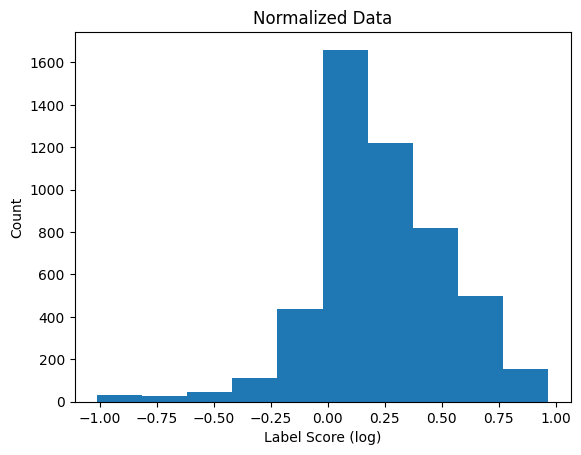

In [7]:
#@title Plot labels

plt.hist(y_labels, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.xlabel("Label Score")
plt.ylabel("Count")
plt.title("Raw Data Capped at Twenty")
plt.show()

plt.hist(y_labels, 500)
plt.xlabel("Label Score")
plt.ylabel("Count")
plt.title("Raw Data")
plt.show()

plt.hist(y_labels, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,500])
plt.xlabel("Label Score")
plt.ylabel("Count")
plt.show()

plt.hist(y_labels, [0,5,300])
plt.xlabel("Label Score")
plt.ylabel("Count")
plt.show()

norm_y_labels = np.log(y_labels)/6
plt.hist(norm_y_labels)
plt.xlabel("Label Score (log)")
plt.ylabel("Count")
plt.title("Normalized Data")
plt.show()

In [8]:
#@title Processing Labels
#print(len(y_labels))
y_labels_new = np.zeros((len(y_labels),2))
for i in range(len(y_labels)):
  if y_labels[i] >= 5:
    #print("here")
    y_labels_new[i,:] = [0,1]
  else:
    y_labels_new[i,:] = [1,0]
#print(y_labels_new)

In [9]:
#@title GPU availability check

import torch
if torch.cuda.is_available():
  print(torch.device('cuda'))
else:
  print(torch.device('cpu'))

cuda


In [10]:
#@title 3D CNN
dims = 64
model_3D_part_input = Input(shape=(dims, dims, dims, 1), name='Input_3D_part')

model3D_1 = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(model_3D_part_input)

model3D_2 = MaxPooling3D(pool_size=(2, 2, 2),strides=2)(model3D_1)

model3D_3 = Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(model3D_2)

model3D_4 = MaxPooling3D(pool_size=(2, 2, 2),strides=2)(model3D_3)

model3D_5 = Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(model3D_4)

model3D_6 = MaxPooling3D(pool_size=(2, 2, 2),strides=2)(model3D_5)

model3D_7 = Flatten()(model3D_6)

model3D_8 = Dense(32, activation='relu')(model3D_7)

model3D_9 = Dense(16, activation='relu')(model3D_8)

model3D_10 = Dense(2, activation='softmax')(model3D_9)

model_final = Model(inputs=[model_3D_part_input],outputs=[model3D_10], name = "final_model")

#Model Details
model_final.summary()
#merged = Concatenate([model, scale])

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_3D_part (InputLayer)  [(None, 64, 64, 64, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 62, 62, 62, 32)    896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 31, 31, 31, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 29, 29, 29, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 14, 14, 14, 64)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 12, 12, 12, 64)    

In [11]:
#@title Wandb Initialization

LR = 0.001
SpE = 200
bSize = 32
Enum = 5
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="3D_CNN_printability",

    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "adam",
        "loss": "mean_absolute_error",
        "epoch": Enum,
        "batch_size": bSize,
        "steps_per_epoch": SpE,
        "learning_rate": LR,
        "classification": 1
    }
)


In [12]:
#@title Train-Validation-Test Data Split
print(models.shape)
models_train, models_test, scale_train, scale_test, y_train, y_test = train_test_split(models, scale, y_labels_new, test_size=0.2, shuffle=True)
print(models_train.shape)
print(models_test.shape)
print(scale_train.shape)
print(scale_test.shape)
print(y_train.shape)
print(y_test.shape)
models_val, models_test, scale_val, scale_test, y_val, y_test = train_test_split(models_test, scale_test, y_test, test_size=0.5, shuffle=True)

(5001, 64, 64, 64, 1)
(4000, 64, 64, 64, 1)
(1001, 64, 64, 64, 1)
(4000,)
(1001,)
(4000, 2)
(1001, 2)


In [13]:
#@title Training Model
#new_learning_rate = 0.01 
#my_optimizer.lr.assign(new_learning_rate)

model_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_final.fit(models_train, y_train, epochs=Enum, batch_size=bSize, steps_per_epoch=SpE, validation_data=(models_val, y_val), callbacks=[
                      WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint("models")
                    ])

Epoch 1/5
  5/200 [..............................] - ETA: 7s - loss: 0.7075 - accuracy: 0.4250

199/200 [============================>.] - ETA: 0s - loss: 0.5587 - accuracy: 0.7076

wandb: Adding directory to artifact (./models)... Done. 0.0s


200/200 [==============================] - 18s 58ms/step - loss: 0.5578 - accuracy: 0.7081 - val_loss: 0.5286 - val_accuracy: 0.7560
Epoch 2/5
199/200 [============================>.] - ETA: 0s - loss: 0.4277 - accuracy: 0.8001

wandb: Adding directory to artifact (./models)... Done. 0.0s


200/200 [==============================] - 10s 51ms/step - loss: 0.4273 - accuracy: 0.8005 - val_loss: 0.4671 - val_accuracy: 0.7940
Epoch 3/5
199/200 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8518

wandb: Adding directory to artifact (./models)... Done. 0.0s


200/200 [==============================] - 10s 49ms/step - loss: 0.3190 - accuracy: 0.8519 - val_loss: 0.5158 - val_accuracy: 0.7920
Epoch 4/5
 25/200 [==>...........................] - ETA: 7s - loss: 0.2780 - accuracy: 0.8725

wandb: Adding directory to artifact (./models)... Done. 0.0s


200/200 [==============================] - 3s 16ms/step - loss: 0.2780 - accuracy: 0.8725 - val_loss: 0.4905 - val_accuracy: 0.8100


In [14]:
#@title Evaluate Model

# Evaluate the model on the test data
loss, accuracy = model_final.evaluate(models_test, y_test, callbacks=[
                      WandbMetricsLogger(log_freq=1),
                      WandbModelCheckpoint("models2")
                    ])
#wandb.log({"acc": accuracy, "loss": loss})
#wandb.log({"loss": loss})
print('Test loss:', loss)

16/16 [==============================] - 1s 44ms/step - loss: 0.4503 - accuracy: 0.8204
Test loss: 0.45032799243927


In [15]:
#@title Finish Wandb

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

batch/accuracy,▁▃▄▄▄▅▅▅▅▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▇▇▇▆▆▆▆▆▄▅▅▅▄▄▄▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁
epoch/accuracy,▁▅▇█
epoch/epoch,▁▃▆█
epoch/learning_rate,▁▁▁▁
epoch/loss,█▅▂▁
epoch/val_accuracy,▁▆▆█
epoch/val_loss,█▁▇▄
batch/accuracy,0.87202
